In [23]:
import jax.numpy as jnp
from fbpinns.problems import Problem

class test3(Problem):
    """Solves the time-dependent damped harmonic oscillator using hard boundary conditions
        du      
        -- = 4cos(4x) + 40cos(40x)
        dx       

        Boundary conditions:
        u (0) = 0
    """

    @staticmethod
    def init_params(sd=0.1):

        static_params = {
            "dims":(1,1),
            "sd":sd,
            }

        return static_params, {}

    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):

        # physics loss
        x_batch_phys = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        required_ujs_phys = (
            (0,(0,)),
        )
        return [[x_batch_phys, required_ujs_phys],]# only physics loss required in this case

    @staticmethod
    def constraining_fn(all_params, x_batch, u):

        sd = all_params["static"]["problem"]["sd"]
        x, tanh = x_batch[:,0:1], jnp.tanh

        u = (tanh(x/sd)) * u# applies hard BCs
        return u

    @staticmethod
    def loss_fn(all_params, constraints):

        # physics loss
        cos = jnp.cos
        x_batch, ux = constraints[0]
        x = x_batch[:, 0:1]
        phys = jnp.mean((4*cos(4*x) + 40*cos(40*x) - ux)**2)

        return phys
    
    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape=None):
        # The exact solution is u(x,y) = sin(πx) sin(πy)
        x = x_batch[:, 0:1]
        sin = jnp.sin
        u = sin(4*x) + sin(40*x)
        return u

True


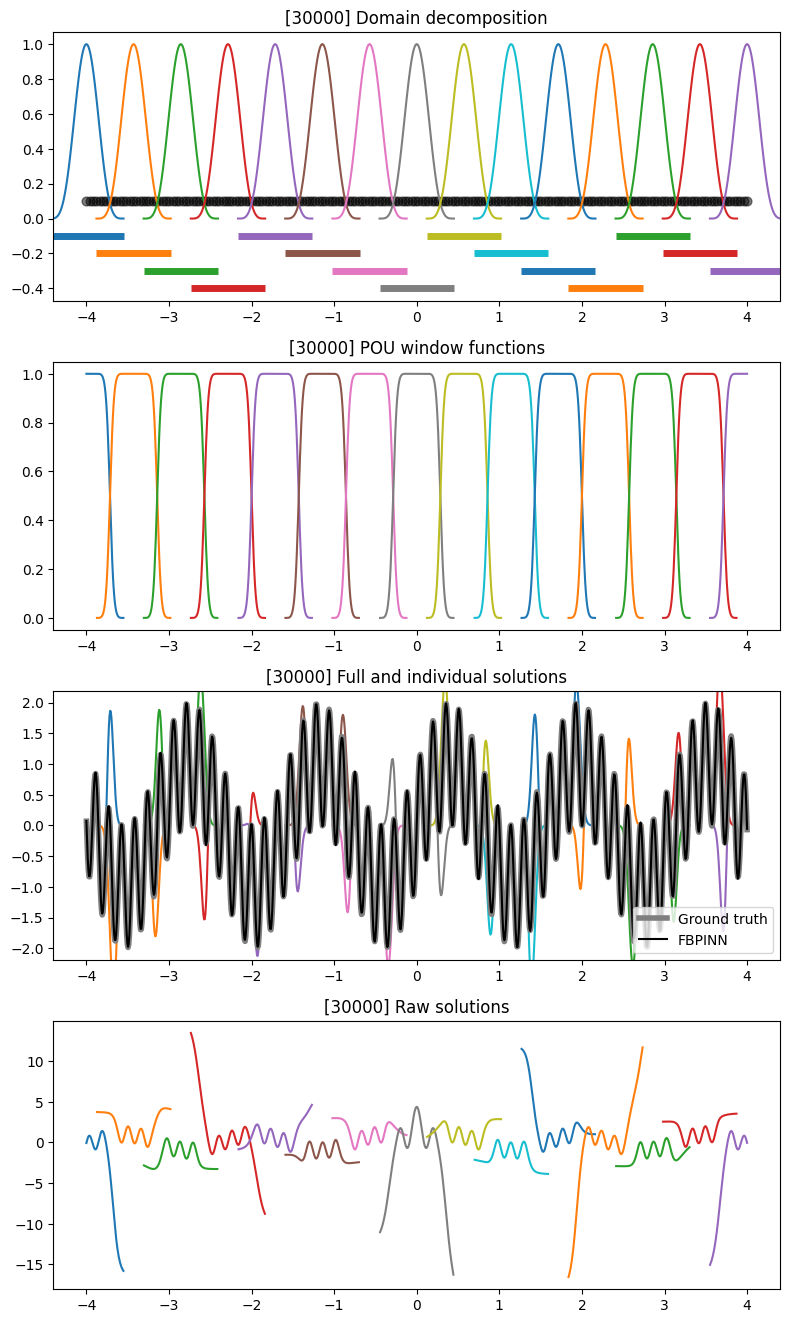

[INFO] 2025-04-14 17:38:41 - [i: 30000/30000] Training complete


In [ ]:
import numpy as np

from fbpinns.domains import RectangularDomainND
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN, ChebyshevKAN, ChebyshevAdaptiveKAN
from fbpinns.constants import Constants
from fbpinns.trainers import FBPINNTrainer, PINNTrainer

c = Constants(
    domain=RectangularDomainND,# use a 1D problem domain [0, 1]
    domain_init_kwargs=dict(
        xmin=np.array([-4,]),
        xmax=np.array([4,]),
    ),
    problem=test3,
    problem_init_kwargs=dict(
    ),
    decomposition=RectangularDecompositionND,# use a rectangular domain decomposition
    decomposition_init_kwargs=dict(
        subdomain_xs=[np.linspace(-4,4,15)],# use 15 equally spaced subdomains
        subdomain_ws=[6*0.15*np.ones((15,))],# with widths of 0.15
        unnorm=(0.,1.),# define unnormalisation of the subdomain networks
    ),
    network=FCN,# place a fully-connected network in each subdomain
    network_init_kwargs=dict(
        layer_sizes=[1, 32, 1],# with 2 hidden layers
    ),
    # network=ChebyshevAdaptiveKAN,
    # network=ChebyshevKAN,
    # network_init_kwargs=dict(
    
    #     input_dim=1,
    #     output_dim=1,
    #     degree=10
    # ),
    ns=((200,),),
    n_test=(1000,),
    n_steps=30000,
    optimiser_kwargs = dict(
        learning_rate=0.01
        ),
    clear_output=True, 
)

run = FBPINNTrainer(c)
all_params = run.train()